# Surface Visualization Demo Notebook, Neurohackweek, 8 Sept 2017

- (Mostly) developted by Murat Bilgel, Benjamin Ely, Melanie Ganz, Krisanne Litinas, and Andrea Shafer
- Heavily indebted to Satra Ghosh, Chris Holdgraf, Anisha Keshavan, and Tal Yarkoni
- Builds on 
[IPyvolume](https://ipyvolume.readthedocs.io/en/latest/index.html), 
[NiBabel cifti2 package](http://nipy.org/nibabel/reference/nibabel.cifti2.html), 
[Michiel Cottaar's cifti tools](https://git.fmrib.ox.ac.uk/ndcn0236/cifti), and [various NHW demo notebooks](https://github.com/neurohackweek)


<b>Load packages etc:</b>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nibabel as nb
import ipyvolume
import ipyvolume.pylab as p3
import numpy as np
import os
import sys
import niwidgets
from niwidgets import NiftiWidget
from niwidgets import niwidget_surface
import nilearn.plotting as nip
from ipywidgets import interact, fixed, IntSlider, FloatSlider
from ipywidgets import interact,fixed,IntSlider
from nilearn import image
from itertools import islice

In [2]:
# NB: added 'export NHW=$HOME/Desktop/nhw2017/NHW_visualization' to ~/.bashrc
nhw = os.environ['NHW'] 
# FYI example data primarily from Human Connectome Project subject 100610
path_lh = nhw+'/data/100610/MNINonLinear/fsaverage_LR32k/100610.L.very_inflated_MSMAll.32k_fs_LR.surf.gii'
data_lh = nb.load(path_lh)
path_rh = nhw+'/data/100610/MNINonLinear/fsaverage_LR32k/100610.R.midthickness_MSMAll.32k_fs_LR.surf.gii'
data_rh = nb.load(path_rh)
path_sc=nhw+'/data/100610/MNINonLinear/ROIs/Atlas_ROIs.2.nii.gz'
data_sc = nb.load(path_sc)

path_lh_myelin = nhw+'/data/100610/MNINonLinear/fsaverage_LR32k/100610.L.MyelinMap.32k_fs_LR.func.gii'
data_lh_myelin = nb.load(path_lh_myelin)
path_rh_myelin = nhw+'/data/100610/MNINonLinear/fsaverage_LR32k/100610.R.MyelinMap.32k_fs_LR.func.gii'
data_rh_myelin = nb.load(path_rh_myelin)

filename = os.path.join(nhw,'data','subjA','subjA_t0_pet_mni.nii.gz')
filename_4D = os.path.join(nhw,'data','subjA','subjA_4D_pet_mni.nii.gz')

path_ciftiTS = nhw+'/data/100610/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean.dtseries.nii'
data_ciftiTS = nb.load(path_ciftiTS)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


<b>Define functions:</b>  
(kindly remind us to define oscale and mwmask before running)

In [3]:
def showSurface(surface,overlay=None,frame=0,newfigure=True,colormap='summer',figsize=np.array([600,600]),
                figlims=np.array([[-100,100],[-100,100],[-100,100]]),mwall=True):
    '''
    Displays a surface mesh in gifti or FreeSurfer (FS) surface format with/without an overlay inside  
    Jupyter notebook for interactive visualization.

    Parameters
    ----------
    surface: str, gifti object
        Path to surface file in gifti or FS surface format or an already loaded gifti object of surface
    overlay: str, gifti object
        Path to overlay file in gifti or FS annot or anaotimcal (.curv,.sulc,.thickness) format or an already loaded 
        gifti object of overlay, default None
    frame: int
        indice of the frame (timepoint or functional data frame) to show
    newfigure: bool
        Create a new figure else prints into the last figure (in order to visualize both hemispheres in 
        one plot), default True
    colormap: string
        A matplotlib colormap, default summer
    figsize: ndarray
        Size of the figure to display, default [600,600]
    figLims: ndarray
        x,y and z limits of the axes, default [[-100,100],[-100,100],[-100,100]])

    '''

    if isinstance(surface,str):
        if not os.path.exists(surface):
            error('File does not exist, please provide a valid file path to a gifti or FreeSurfer file.')
        filename, file_extension = os.path.splitext(surface)
        if file_extension is '.gii':
            surface = nb.load(surface)
        else:
            fsgeometry = nb.freesurfer.read_geometry(surface)
            x,y,z = fsgeometry[0].T
            vertex_edges=fsgeometry[1]

    if isinstance(surface,nb.gifti.gifti.GiftiImage):
        try:
            vertex_spatial=surface.darrays[0]
            vertex_edges=surface.darrays[1]
            x, y, z = vertex_spatial.data.T
        except:
            raise ValueError('Please provide a valid gifti file.')

    
    if mwall is False:
        try:
            mkeep,mkill=mwmask(surface,overlay)
        except:
            raise ValueError('Overlay required for medial wall masking.')
    
    if not isinstance(frame,int):
        ValueError('Please provide a valid integer frame index.')
    
    if isinstance(overlay,list):
        if frame>len(overlay) or frame < 0:
            error('Frame index out of bounds, please provide a valid frame index.')
        overlay = overlay[frame]
    
    if isinstance(overlay,str):
        if not os.path.exists(overlay):
            error('File does not exist, please provide a valid file path to a gifti or FreeSurfer file.')
        filename, file_extension = os.path.splitext(overlay)
        
        if file_extension is '.gii':
            overlay = nb.load(overlay)
        elif (file_extension in ('.annot','')):
            annot = nb.freesurfer.read_annot(overlay)
            activation = annot[0]
        elif (file_extension in ('.curv','.thickness','.sulc')):
            activation = nb.freesurfer.read_morph_data(overlay)
        elif (file_extension in ('.dlabel.nii','.dscalar.nii','.dconn.nii','.dtseries.nii')):
            left,right,sub=csplit(overlay)
            
    if isinstance(overlay,nb.gifti.gifti.GiftiImage):
        try:
            activation=overlay.darrays[0].data
        except:
            raise ValueError('Please provide a valid gifti file')
            
    # WARNING: still in development
    if isinstance(overlay,nb.cifti2.cifti2.Cifti2Image):
        try:
            left,right,sub=csplit(overlay)
            activation=left.copy() 
        except:
            raise ValueError('Please provide a valid cifti file.')
    
    
    if newfigure:

        fig = p3.figure(width=figsize[0], height=figsize[1])
        fig.camera_fov = 1
        fig.style = {'axes': {'color': 'black',
          'label': {'color': 'black'},
          'ticklabel': {'color': 'black'},
          'visible': False},
         'background-color': 'white',
         'box': {'visible': False}}
        fig.xlim = (figlims[0][0], figlims[0][1])
        fig.ylim = (figlims[1][0], figlims[1][1])
        fig.zlim = (figlims[2][0], figlims[2][1])

        
    # plot surface
    if overlay is None:
        p3.plot_trisurf(x, y, z, triangles=vertex_edges.data)
    elif mwall is False:
        my_color = plt.cm.get_cmap(colormap)
        colors=my_color(oscale(activation))
        p3.plot_trisurf(x, y, z, triangles=vertex_edges.data[mkeep], color=colors[:,:3])
    else:
        my_color = plt.cm.get_cmap(colormap)
        colors=my_color(oscale(activation))
        p3.plot_trisurf(x, y, z, triangles=vertex_edges.data, color=colors[:,:3])

    if newfigure:
        p3.show()
        
    return 1

In [4]:
def mwmask(surf,mask):
    '''
    mask out medial wall; with some tinkering could be used to mask any vertices of (no) interest
    surf and mask should be .gii or cifti structures loaded with nibabel
    surf is the target surface
    mask is an overlay with no information at medial wall vertices (e.g. myelin map)
    '''
    keep=(mask.darrays[0].data!=0)
    kill=(mask.darrays[0].data==0)
    ikeep=[i for i, e in enumerate(keep) if e != 0]
    ikill=[i for i, e in enumerate(kill) if e != 0]
    killdict={ii:1 for ii in ikill} # fun fact, iterating over a dictionary is ~exponentially faster vs. over a list
    mask_kill=np.zeros([surf.darrays[1].data.shape[0]],dtype=bool) # create empty arrays matching surface mesh dimentions
    mask_keep=mask_kill.copy()
    for ii, row in enumerate(surf.darrays[1].data):
        for item in row:
            if item in killdict.keys():
                mask_kill[ii]=True
                continue
            else:
                mask_keep[ii]=True
                continue
    return mask_keep,mask_kill

In [5]:
def oscale(olay):
    # scales input array values to between zero and one, as needed for iPyVolume colormaps
    # for now, olay must be a 1D array (single timepoint)
    scaled=np.asarray((olay-min(olay))/(max(olay)-min(olay)))
    return scaled

In [6]:
# showSurface example:
showSurface(data_rh) # right surface only
showSurface(data_rh,data_rh_myelin) # new plot, same surface but with myelin map overlay
showSurface(data_lh,data_lh_myelin,newfigure=False,mwall=False) # same plot, added "very inflated" left surface, excluded medial wall

A Jupyter Widget

A Jupyter Widget

1

<b>NiWidgets 4D longitudinal or timeseries display:</b>

In [7]:
# 1) get the default plotter in niwidgets and manipulate it.
# 2) write function for an spaghetti plot showing the longitudinal trend at selected voxel

def plot_timepoint_slices(data, figure, x, y, z, t=0, colormap='viridis', figsize=(15, 5)):
    """
    Plots x,y,z slices at time point t.
    """
    
    coords = [x, y, z]
    views = ['Sagittal', 'Coronal', 'Axial']
    
    axes = [figure.add_subplot(231), figure.add_subplot(232), figure.add_subplot(233),
            figure.add_subplot(234)]
    
    
    data = data.dataobj.get_unscaled()
    print(data.shape)
    for subplot in range(3):
        slice_obj = 3 * [slice(None)] + [t]
        slice_obj[subplot] = coords[subplot]

        plt.sca(axes[subplot])
        axes[subplot].set_facecolor('black')
        axes[subplot].set_title(views[subplot])
        axes[subplot].tick_params(
            axis='both', which='both', bottom='off', top='off',
            labelbottom='off', right='off', left='off', labelleft='off'
            )
        # fix the axis limits
        axis_limits = [limit for i, limit in enumerate(data.shape)
                       if i != subplot]
        axes[subplot].set_xlim(0, axis_limits[0])
        axes[subplot].set_ylim(0, axis_limits[1])

        # plot the actual slice
        if subplot == 0:
            plt.imshow(np.flipud(np.rot90(data[slice_obj], k=1)),
                       cmap=colormap)
        else:
            plt.imshow(np.rot90(data[slice_obj], k=3), cmap=colormap)
        # draw guides to show where the other two slices are
        guide_positions = [val for i, val in enumerate(coords)
                           if i != subplot]
        plt.axvline(x=guide_positions[0], color='gray', alpha=0.8)
        plt.axhline(y=guide_positions[1], color='gray', alpha=0.8)

    #plt.sca(axes[-1])
    axes[-1].plot(range(data.shape[3]),data[x,y,z,:],'o-')
    axes[-1].plot(t,data[x,y,z,t],'ro')
    axes[-1].set_xlabel('Time point')
    axes[-1].set_ylabel('Intensity')
    
    # show the plot
    plt.show()
    # print the value at that point in case people need to know
    print('Value at point {x}, {y}, {z}, {t}: {intensity}'.format(
        x=x, y=y, z=z, t=t, intensity=data[x, y, z, t]
    ))

In [8]:
# example volumetric 4D data:
my_4D_widget = NiftiWidget(filename_4D)
my_4D_widget.nifti_plotter(plotting_func=plot_timepoint_slices, 
                           x=IntSlider(90, min=0, max=181, continuous_update=False),
                           y=IntSlider(100, min=0, max=217),
                           z=IntSlider(90, min=0, max=181),
                           t=IntSlider(min=0, max=3))

A Jupyter Widget

In [9]:
# example surface 4D data:
meshfile_lh_inflated = nhw+'/data/006/surf/lh.inflated'
overlayfiles_lh = [nhw+'/data/006/surf/lh.thickness',nhw+'/data/006/surf/lh.curv']
sw = niwidget_surface.SurfaceWidget(meshfile=meshfile_lh_inflated,
                                    overlayfiles = overlayfiles_lh)
sw.surface_plotter()
sw.fig

A Jupyter Widget

A Jupyter Widget

<b>Tangentially related CIFTI tools:</b>

In [10]:
def cread(infile):
    # loads a cifti file and stores the data and four metadata objects
    # should be called as: cd,ch,cn,cx,cf=cread(input_cifti)
    cin=nb.load(infile)
    cdata=np.asarray(cin.get_data()).copy()
    chead=cin.header.copy()
    cnhdr=cin.nifti_header.copy()
    cxtra=cin.extra.copy()
    cfmap=cin.file_map.copy()
    return cdata,chead,cnhdr,cxtra,cfmap

In [25]:
# cread example:
input_cifti=nhw+'/rfMRI_REST1_LR_Atlas_MSMAll_hp2000_clean.dtseries.nii'
cd,ch,cn,cx,cf=cread(input_cifti)
print(cd.data.shape)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(1200, 91282)


In [12]:
def csave(filename,cdata,chead=None,cnhdr=None,cxtra=None,cfmap=None):
    # saves a cifti data structure to file. Output likely unusable without some header info
    cout=nb.Cifti2Image(dataobj=cdata,header=chead,nifti_header=cnhdr, extra=cxtra, file_map=cfmap)
    cout.to_filename(filename)

In [13]:
# csave example:
output_cifti=nhw+'/save_demo.dtseries.nii'
csave(output_cifti,cd,ch,cn,ch,cf)

In [14]:
def clthresh(data,thresh,setto=0):
    # set all values below threshold to a given value (default 0)
    lthr_data=data.copy()
    lthr_data[lthr_data<thresh]=setto
    return lthr_data

In [15]:
def cuthresh(data,thresh,setto=0):
    # set all values above threshold to a given value (default 0)
    uthr_data=data.copy()
    uthr_data[uthr_data>thresh]=setto
    return uthr_data

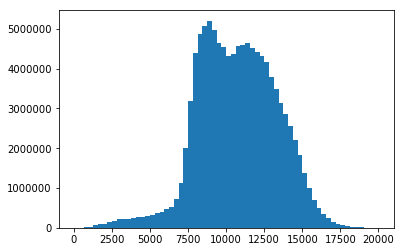

In [16]:
# clthresh/cuthresh example:
p1=plt.hist(cd[np.nonzero(cd)], 64,[0,20000])

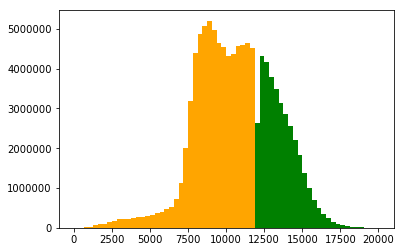

In [32]:
tl12000_cd=clthresh(cd,12000)
tu12000_cd=cuthresh(cd,12000)
p1=plt.hist(tu12000_cd[np.nonzero(tu12000_cd)], 64, [0,20000],color='Orange')
p1=plt.hist(tl12000_cd[np.nonzero(tl12000_cd)], 64, [0,20000],color='Green')
output_cifti=nhw+'/thresh_demo.dtseries.nii'
csave(output_cifti,tl12000_cd,ch,cn,ch,cf)

In [18]:
def cmask(cdata1,cdata2):
    # masks cifti data 1 with non-zero values of cifti data 2
    # cdata2 can be a single timepoint or matched to cdata1 dimensions
    masked_cdata1=cdata1.copy()
    if cdata1.shape != cdata2.shape:
        mask=np.tile(cdata2,(cdata1.shape[0],1))
    else:
        mask=cdata2.copy()
    masked_cdata1[mask==0]=0
    return masked_cdata1

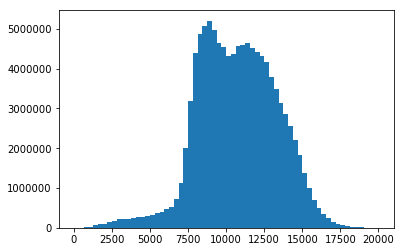

In [19]:
# cmask example:
plt.hist(cd[np.nonzero(cd)],64,[0,20000]);

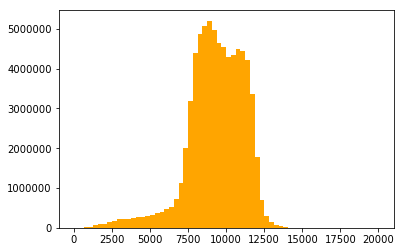

In [20]:
masked3d=cmask(cd,tu12000_cd[0]) # masking 4d timeseries with single 3d timepoint
plt.hist(masked3d[np.nonzero(masked3d)],64,[0,20000],color='Orange');

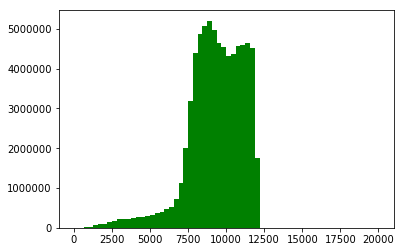

In [34]:
masked4d=cmask(cd,tu12000_cd)    # masking 4d timeseries with 4d timeseries
plt.hist(masked4d[np.nonzero(masked4d)],64,[0,20000],color='Green');

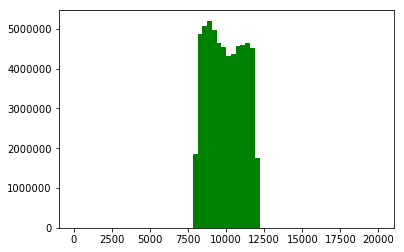

In [38]:
tl8000_cd=clthresh(cd,8000)
range4d=cmask(tl8000_cd,tu12000_cd)    # masking 4d timeseries with 4d timeseries
plt.hist(range4d[np.nonzero(range4d)],64,[0,20000],color='Green');
output_cifti=nhw+'/range_demo.dtseries.nii'
csave(output_cifti,range4d,ch,cn,ch,cf)

Other stuff still in development:

In [22]:
def csplit(incifti):
    # split cifti overlay into separate left surface/right surface/subcortical voxel values
    # incifti can be a file location string or loaded cifti object
    
    if isinstance(incifti,nb.cifti2.cifti2.Cifti2Image):
        cd=np.asarray(incifti.get_data()).copy()
        ch=incifti.header.copy()
    else:
        cd,ch,cn,cx,cf=cread(incifti) 
    
    mim = ch.matrix[1]
    bm1 = list(mim.brain_models)[0]
    bm2 = list(mim.brain_models)[1]
    lidx = list(bm1.vertex_indices)
    ridx = [bm1.surface_number_of_vertices + val for val in bm2.vertex_indices]
    bidx = np.concatenate((lidx, ridx))
    # debug:
    # print(bidx.shape)
    #    for idx, bm in enumerate(mim.brain_models):
    #        print((idx, bm.index_offset, bm.brain_structure))
    
    # split cifti overlay into left surface, right surface, and subcortical volume
    clh=cd[:,0:len(lidx)]
    crh=cd[:,len(lidx):len(lidx)+len(ridx)+1]
    csc=cd[:,len(lidx)+len(ridx)+1:cd.shape[1]]
    return clh, crh, csc

In [23]:
def cplot(coverlay,lsurf,rsurf,subvol,colormap):
    # plots cifti overlay data with specified color on surfaces/subcortex
    # lsurf and rsurf should be .surf.gii files matched to the number of vertices in each cifti hemisphere
    # subvol should be a HCP-style subcortical volume (e.g. Atlas_ROIs.2.nii.gz)
    
    # import packages
    import nibabel as nb
    import matplotlib.pyplot as plt
    import ipyvolume
    import ipyvolume.pylab as p3
    import numpy as np
    
    # read input files
    ls=nb.load(lsurf)
    rs=nb.load(rsurf)
    sv=nb.load(subvol)
    
    # parse surface structure
    lxyz=ls.darrays[0]
    rxyz=rs.darrays[0]
    lmesh=ls.darrays[1]
    rmesh=rs.darrays[1]
    
    # plot
    showSurface(lsurf,coverlay,mwall=False)
    
#    return 1
    